# Convolutional Neural Networks in `PyTorch`

This tutorial was heavily borrowed from the [d2l.ia](http://d2l.ai/). Major changes made include:
* Simplification and adaptation to cpu-only implementation
* Comments and descriptions of the functions

Note the sample code in the d2l.ia [repo](https://github.com/d2l-ai/d2l-en) is subject to a modified [MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np
# import tute.helper as helper
# from tute.helper import Accumulator

random.seed(2021)

### <font color='red'>STOP: Run the two helper function cells below before proceeding</font>

In [2]:
# from importlib import reload
# helper = reload(helper)

## About the Data

* MNIST is a repository of images containing hand-written digits (0-9) used as a canonical test for CNNs
* Today we will be using a slightly different dataset known as *fashion* MNIST
* Fashion MNIST dataset can be obtained by a quick google search and in places such as [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist)

#### About Fashion MNIST
* Each instance/example is a single image (28x28 pixels -- a total of 784 pixels)
* The entire image is represented by a `torch.tensor()` object (effectively a matrix)
* The value in each pixel represents the darkness of each pixel (0 to 255)
* Each image is categorised as follows:
    0. T-shirt/top
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt
    7. Sneaker
    8. Bag
    9. Ankle Boot
* There are 70,000 instances of these images

The library `torchvision` provides access to various repositories of training data (such as the Fashion MNIST). Here we write a function to download data from the `torchvision` servers and save it into our local directory. Note this is saved usually in the `anaconda` folder of your personal drive if you are using Anaconda. There is something special about this format we will discuss soon.

#### Train-Test Set
Best practice for machine learning dictates you separate your labelled data into three groups:
* `Train` -- this is the data we use to fit the model (n=60,000)
* `Validate` -- we will not be using this today to tune hyper-parameters
* `Test` -- this is the data we use to determine the model performance (n=10,000)

In [4]:
# change the num_worker option to n_workers = 4 if you are using a decent CPU system
# change the num_worker option to 4 * n_gpu if you have GPUs 
def load_data_fashion_mnist(batch_size, n_workers=0 , resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

#### `torch.utils.data.DataLoader` format
Typically, when you work with datasets, you download it into your directory and you work directly with it. This is fine for smaller datasets, but when you work with massive datasets this can be unworkable. You may not have enough RAM to store the dataset in memory, and often times, you don't *need* to use all the data at the same time. `torch` comes with a useful class called `DataLoader`. Rather than directly download your dataset, it allows you to define an iterable. With an iterable, you only access the data when needed using special functions, ensuring both parallisability and efficiency.

First we must determine a batch-size:
* Small batch sizes ensures frequent updating of the model (leading to fewer epochs required), but can be more computationally expensive
* Large batch sizes are easier to run but can require more epochs to converge

In [5]:
batch_size = 1024
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size) # n=60000

You may get the following error:

```
C:\Users\Brian\anaconda3\envs\ML-sandbox\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  
```

This can be ignored

In [6]:
print(train_iter)

Okay, so it appears that I can't print out the value of `train_iter` since it's a dataloader object. This makes sense since this is a generator object. We need to think of more creative ways of outputting this. First let's think about how many units we expect in `train_iter`. There are 60,000 training examples, and we batch them up into batch sizes of 256 -- this means there should be 235 batches (rounded up as the final batch will have less than 256 units, but that's fine).

In [7]:
print(len(train_iter))

235


This is as expected! In order to print out an individual example or batch, we need to randomly sample from the generator. For example's sake let's get 3 batches.

In [9]:
sampled_batches = random.sample(list(train_iter), 3)
len(sampled_batches) # shows how many batches there are

3

In [8]:
len(sampled_batches[0])

2

In [9]:
# For argument's sake let's choose the 3rd batch
batch_no = 2

# The object is a list of lists -- each batch with two entries
# 0 denotes the predictors
# 1 denotes the labels
predictor = sampled_batches[batch_no][0]
label = sampled_batches[batch_no][1]

print("The number of exampels in the batch of the predictors are: ", len(predictor))
print("The number of exampels in the batch of the labels are: ", len(label))
print("They should be equal!")

The number of exampels in the batch of the predictors are:  256
The number of exampels in the batch of the labels are:  256
They should be equal!


In [10]:
# Let's choose a single example from the batch
single_predictor = predictor[100]
single_label = label[100]
print("The shape of the predictor", single_predictor.shape)
print("The shape of the predictor", single_label.shape)

The shape of the predictor torch.Size([1, 28, 28])
The shape of the predictor torch.Size([])


You should get the following:
* Predictor: `[1,28,28]` -- this means it's a tensor with a single channel and 28x28 (if it was RGB colour it would be `[3,28,28]`)
* Label: `[]` -- this means it's a scalar

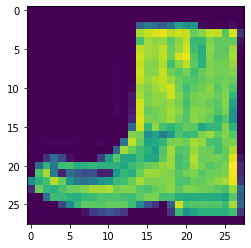

This shows an image of:  9


In [11]:
plt.imshow(single_predictor[0]) # print only the one channel of BW
plt.show()

print("This shows an image of: ", int(single_label))

## Network Architecture

There are 3 main tools we will use:
1. `Conv2d` -- A convolution thru the image matrix (***cross-correlation operation***)
2. `AvgPool2d` -- Pooling layer
3. `Linear` -- Linear Neural Network (normal) layer (if you are familar with tensorflow this is known as the dense layer)

In between we will be using additional tools such as `Sigmoid` for activation functions and `Flatten` to convert our convolutional matrices into linear inputs.

### Convolution
There are 4 arguments to the `Conv2d`.
1. Input:
2. Output:
3. Kernel Size:
4. Stride:

https://cs231n.github.io/convolutional-networks/

http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html?highlight=cross%20correlation

Note that we ignore the final Guassian activation layer from the original paper following the d2l tutorial

In [21]:
# Initialise LeNet Architecture
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [22]:
# Show layers
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:    \t', X.shape)

Conv2d output shape:    	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:    	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:    	 torch.Size([1, 6, 14, 14])
Conv2d output shape:    	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:    	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:    	 torch.Size([1, 16, 5, 5])
Flatten output shape:    	 torch.Size([1, 400])
Linear output shape:    	 torch.Size([1, 120])
Sigmoid output shape:    	 torch.Size([1, 120])
Linear output shape:    	 torch.Size([1, 84])
Sigmoid output shape:    	 torch.Size([1, 84])
Linear output shape:    	 torch.Size([1, 10])


### A note on `grad`
Each tensor will have an option of grad or nograd. By default it is `false`. When evaluating an NN, this is the option we need, since we don't want it to track the history (required for calculating gradients). However, when training, we need to keep this on so that we can do autodiff. 

In [23]:
single_predictor.requires_grad

False

We need to set initial NN weights -- usually this is using the Xavier uniform distribution.

## Training with a single mini-batch

In [24]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights) # nb: this takes in a function as an argument

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
lr = 0.9 # Learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr) # Using SGD algorithm ot optimise
loss = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# timer = Timer() 
num_batches = len(train_iter) 

In [26]:
metric = Accumulator(3) # define a 3d accumulator
net.train() # This doesn't actually train, but sets the network on training mode

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
X, y = next(iter(train_iter)) # Pick one batch

In [28]:
optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
y_hat = net(X) # Forward pass on the data to make prediction
l = loss(y_hat, y) # calculate the loss 
l.backward() # back propagate the loss
optimizer.step() # step forward in optimisation

In [29]:
metric_1 = l * X.shape[0]
metric_2 = accuracy(y_hat, y)
metric_3 = X.shape[0] 


print("1. The mini-batch loss is: \t\t\t\t", metric_1)
print("2. The number of correct training predictions is: \t", metric_2)
print("3. The number of total training predictions is: \t", metric_3)

print("This means we get a training accuracy of ", metric_2/metric_3)
print("The average loss for each instance is ", float(metric_1/metric_3))

1. The mini-batch loss is: 				 tensor(650.8555, grad_fn=<MulBackward0>)
2. The number of correct training predictions is: 	 23.0
3. The number of total training predictions is: 	 256
This means we get a training accuracy of  0.08984375
The average loss for each instance is  2.5424041748046875


In [30]:
test_accuracy = evaluate_accuracy(net, test_iter)
print("The testing accuracy is: ", test_accuracy)

The testing accuracy is:  0.1


As you can see both the training and testing accuracy is horrible, floating at around 10%. This is no better than randomly assigning labels to the examples. However, this makes sense, since we only trained on a single batch.

## Training with more examples

In [31]:
net.apply(init_weights) # let's reset the NN weights

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
timer = Timer() 
num_epochs = 7
# animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
#                             legend=['train loss', 'train acc', 'test acc'])

train_accuracy = np.array([])
test_accuracy = np.array([])
epochs = np.arange(num_epochs) + 1

for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3) # define a 3d accumulator
    net.train() # train over one epoch
    for i, (X, y) in enumerate(train_iter): # Loop thru each mini-batch
        timer.start()
        optimizer.zero_grad() # before running the forward/backward pass we need to reset the gradient (otherwise it accumulates)
        y_hat = net(X) # Forward pass on the data to make prediction
        l = loss(y_hat, y) # calculate the loss 
        l.backward() # back propagate the loss
        optimizer.step() # step forward in optimisation
        with torch.no_grad():
            metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0]) # mini-batch loss,  # matches, # total examples
        timer.stop()
        train_l = metric[0] / metric[2] # loss per unit 
        train_acc = metric[1] / metric[2] # training accuracy
        # regularly update animator
#         if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
#             animator.add(epoch + (i + 1) / num_batches,
#                          (train_l, train_acc, None))
    test_acc = evaluate_accuracy(net, test_iter)
    
    train_accuracy = np.append(train_accuracy, train_acc)
    test_accuracy = np.append(test_accuracy, test_acc)
#     animator.add(epoch + 1, (None, None, test_acc))
print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
      f'test acc {test_acc:.3f}')
# print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
#       f'on')
print(f'{timer.sum():.1f} sec taken ')

loss 0.464, train acc 0.826, test acc 0.807
53.1 sec taken 


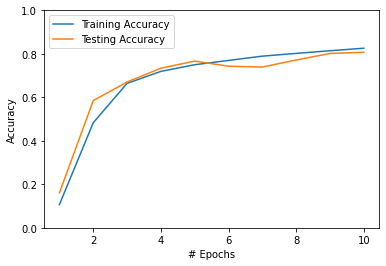

In [33]:
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, test_accuracy, label = "Testing Accuracy")
plt.ylim(0, 1)
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

---

# HELPER FUNCTIONS
Please run the TWO cells below directly after the preamble

In [19]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def print(self):
        print(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # ensure there's more than one example 
        y_hat = argmax(y_hat, axis=1) # Choose the column corresponding to theb highest y_hat
    cmp = astype(y_hat, y.dtype) == y # see if it matches
    return float(reduce_sum(astype(cmp, y.dtype))) #check how many matches there are

astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)

def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module): # Check if net is a nn.Module (type)
        net.eval()  # Set the model to evaluation mode
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [20]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_normal_distribution_and_squared_loss`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.
    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

---

You may notice that if you try to print the `train_iter` or `test_iter`, you'll get some weird object rather than the data itself. The reason for this is that we have opted to load the data via **generator functions** rather than directly. This means that unless the data is required at this moment, we will not need to store it, thus saving memory space. This method is often used in deep learning as the datasets we work with are often huge and cannot be stored properly in memory.

# Convolutional Neural Networks in `PyTorch`

In this tutorial, we will be building a Convolutional Neural Network (CNN) from the ground up using the `Python` library `PyTorch`. There are two main competing libraries when it comes to implementing neural networks in `Python`:
 * `tensorflow`: written with productionisation in mind
 * `pytorch`: written with experimentation and development of novel methods in mind

For basic implementations of neural networks, most people use the package `keras` as a front-end to `tensorflow`. This allows the developer to build simple architectures with easy. `pytorch` does not come with a similar front-end, but its complexity also allows a huge level of flexibility

## Convolutional Neural Networks
CNNs are neural network architectures which facilitates the processing of image data using a technique called a convolution (or a window function). The very first CNN was pioneered by Yann LeCun -- often known as one of the founding fathers of neural networks -- in 1998 [here](https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition).

CNNs have to contend with the particularly challenging structure of image data. For simplicity sake, we will limite ourselves to a 28x28 black and white image. With 28x28 pixels, we have a total of 784 pixels with some sense of local 2D structure. Each pixel has a single channel which represents the lightness (or darkness) of that particular point.

**NOTE** This tutorial is heavily dependent on the classes defined in [d2l](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py), which have been forked for convenience